<a href="https://colab.research.google.com/github/manpreetlotay99/openai/blob/main/virtualfashion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
! git lfs install
! git clone https://github.com/timojl/clipseg
! pip install diffusers -q
! pip install transformers -q -UU ftfy gradio
! pip install git+https://github.com/openai/CLIP.git -q

Git LFS initialized.
Cloning into 'clipseg'...
remote: Enumerating objects: 229, done.
remote: Counting objects: 100% (87/87), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 229 (delta 73), reused 57 (delta 57), pack-reused 142
Receiving objects: 100% (229/229), 1.40 MiB | 24.27 MiB/s, done.
Resolving deltas: 100% (127/127), done.
  Preparing metadata (setup.py) ... done


In [26]:
from huggingface_hub import notebook_login

notebook_login()

In [27]:
%cd clipseg

/clipseg


In [28]:
!ls

clip_masking_lvis_image_ids.yml  Quickstart.ipynb
datasets			 README.md
environment.yml			 sample_rd64.png
evaluation_utils.py		 sample_rd64_refined.png
example_image.jpg		 score.py
experiments			 setup.py
general_utils.py		 supplementary.pdf
LICENSE				 Tables.ipynb
metrics.py			 training.py
models				 Visual_Feature_Engineering.ipynb
overview.png


In [29]:
import torch
import requests
import cv2
from models.clipseg import CLIPDensePredT
from PIL import Image
from torchvision import transforms
from matplotlib import pyplot as plt

from io import BytesIO

from torch import autocast
import requests
import PIL
import torch
from diffusers import StableDiffusionInpaintPipeline as StableDiffusionInpaintPipeline

In [30]:
model = CLIPDensePredT(version='ViT-B/16', reduce_dim=64)
model.eval();

In [31]:
!wget https://owncloud.gwdg.de/index.php/s/ioHbRzFx6th32hn/download -O weights.zip
!unzip -d weights -j weights.zip

--2023-08-02 12:35:37--  https://owncloud.gwdg.de/index.php/s/ioHbRzFx6th32hn/download
Resolving owncloud.gwdg.de (owncloud.gwdg.de)... 134.76.23.45
Connecting to owncloud.gwdg.de (owncloud.gwdg.de)|134.76.23.45|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘weights.zip’

weights.zip             [    <=>             ]   9.68M  11.9MB/s    in 0.8s    

2023-08-02 12:35:38 (11.9 MB/s) - ‘weights.zip’ saved [10146905]

Archive:  weights.zip
 extracting: weights/rd16-uni.pth    
 extracting: weights/rd64-uni-refined.pth  
 extracting: weights/rd64-uni.pth    


In [32]:
model.load_state_dict(torch.load('/content/clipseg/weights/rd64-uni.pth', map_location=torch.device('cuda')), strict=False);

In [33]:
device = "cuda"
pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "CompVis/stable-diffusion-v1-4",
    revision="fp16",
    torch_dtype=torch.float16,
    use_auth_token=True
).to(device)

unet/diffusion_pytorch_model.safetensors not found
/usr/local/lib/python3.10/dist-packages/diffusers/pipelines/pipeline_utils.py:975: FutureWarning: You are using a legacy checkpoint for inpainting with Stable Diffusion, therefore we are loading the <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_inpaint_legacy.StableDiffusionInpaintPipelineLegacy'> class instead of <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_inpaint.StableDiffusionInpaintPipeline'>. For better inpainting results, we strongly suggest using Stable Diffusion's official inpainting checkpoint: https://huggingface.co/runwayml/stable-diffusion-inpainting instead or adapting your checkpoint CompVis/stable-diffusion-v1-4 to the format of https://huggingface.co/runwayml/stable-diffusion-inpainting. Note that we do not actively maintain the {StableDiffusionInpaintPipelineLegacy} class and will likely remove it in version 1.0.0.
  deprecate("StableDiffusionInpaintPipelineLegacy", 

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.
/usr/local/lib/python3.10/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion_inpaint_legacy.py:144: FutureWarning: The class <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_inpaint_legacy.StableDiffusionInpaintPipelineLegacy'> is deprecated and will be removed in v1.0.0

In [34]:
# Image should be of 512x512 size

# image_url = 'https://okmagazine.ge/wp-content/uploads/2021/04/00-promo-rob-pattison-1024x1024.jpg'
image_url = "https://frescafashion.com.au/wp-content/uploads/2023/05/Kob_9WVQ.jpeg"
# image_url = "https://img.freepik.com/free-photo/young-beautiful-woman-pink-warm-sweater-natural-look-smiling-portrait-isolated-long-hair_285396-896.jpg"
input_image = Image.open(requests.get(image_url, stream=True).raw)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.Resize((512, 512)),
])
img = transform(input_image).unsqueeze(0)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [35]:
%cd ..

/


In [36]:
input_image.convert("RGB").resize((512, 512)).save("init_image.png", "PNG")

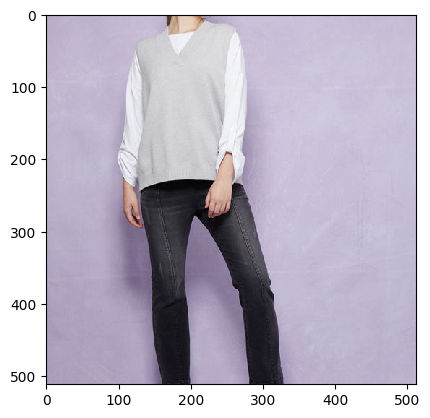

In [37]:
from matplotlib import pyplot as plt
plt.imshow(input_image, interpolation='nearest')
plt.show()

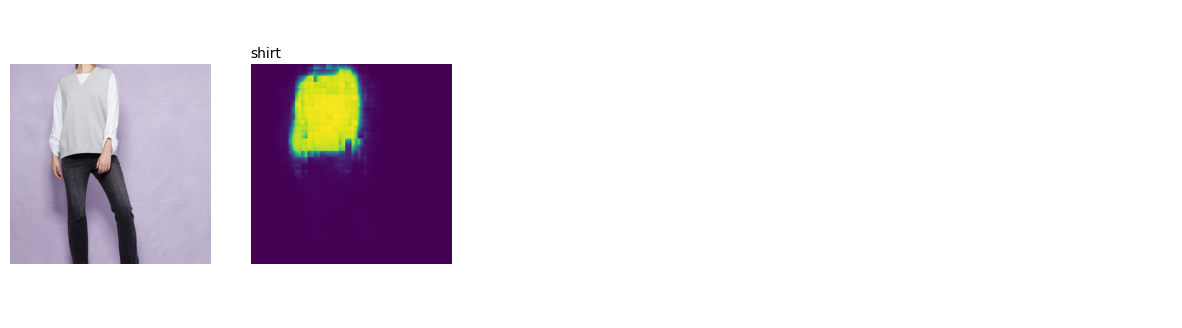

In [38]:
prompts = ['shirt']

with torch.no_grad():
    preds = model(img.repeat(len(prompts),1,1,1), prompts)[0]


_, ax = plt.subplots(1, 5, figsize=(15, 4))
[a.axis('off') for a in ax.flatten()]
ax[0].imshow(input_image)
[ax[i+1].imshow(torch.sigmoid(preds[i][0])) for i in range(len(prompts))];
[ax[i+1].text(0, -15, prompts[i]) for i in range(len(prompts))];

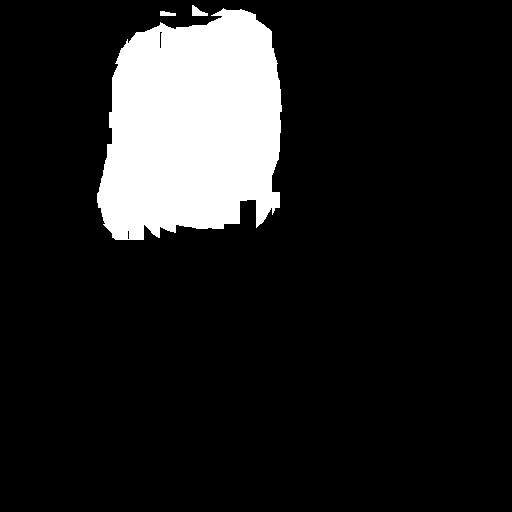

In [39]:
filename = f"mask.png"
plt.imsave(filename,torch.sigmoid(preds[0][0]))

img2 = cv2.imread(filename)

gray_image = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

(thresh, bw_image) = cv2.threshold(gray_image, 100, 255, cv2.THRESH_BINARY)

# For debugging only:
cv2.imwrite(filename,bw_image)

# fix color format
cv2.cvtColor(bw_image, cv2.COLOR_BGR2RGB)

Image.fromarray(bw_image)

In [40]:
init_image = Image.open('init_image.png')
mask = Image.open('mask.png')

  0%|          | 0/40 [00:00<?, ?it/s]

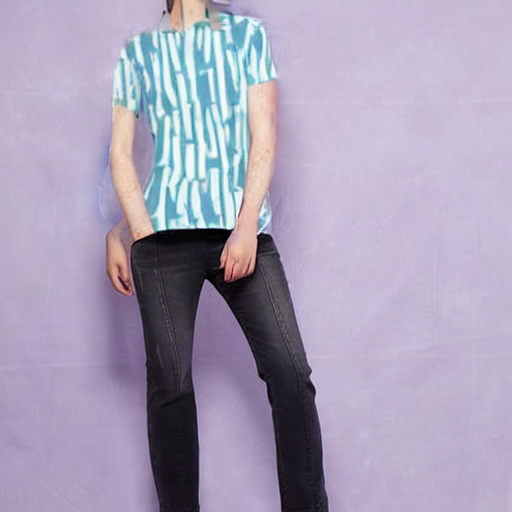

In [41]:
with autocast("cuda"):
    output_image = pipe(prompt="pqr shirt pattern", image=init_image, mask_image=mask, strength=0.8).images[0]

output_image

In [42]:
shirt_image_url = "https://media.istockphoto.com/id/488160041/photo/mens-shirt.jpg?s=612x612&w=0&k=20&c=xVZjKAUJecIpYc_fKRz_EB8HuRmXCOOPOtZ-ST6eFvQ="
shirt_input_image = Image.open(requests.get(shirt_image_url, stream=True).raw)


In [43]:
shirt_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.Resize((512, 512)),
])
shirt_img = shirt_transform(shirt_input_image).unsqueeze(0).to(device)


  0%|          | 0/40 [00:00<?, ?it/s]

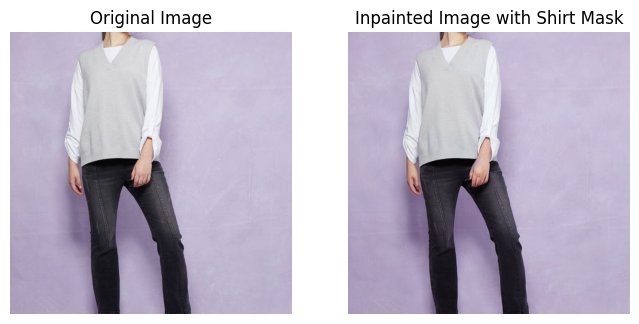

In [49]:
shirt_mask_pil = transforms.ToPILImage()(shirt_img[0].cpu())

# Combine the images by using the shirt image as a mask using the `pipe` object
with autocast("cuda"):
    dummy_prompt = "Blue formal shirt"
    output_image = pipe(prompt=dummy_prompt, image=init_image, mask_image=shirt_mask_pil, strength=0.8).images[0]

_, ax = plt.subplots(1, 2, figsize=(8, 4))
[a.axis('off') for a in ax.flatten()]
ax[0].imshow(input_image)
ax[0].set_title("Original Image")
ax[1].imshow(output_image)
ax[1].set_title("Inpainted Image with Shirt Mask")
plt.show()

Shirt Mask PIL Image:


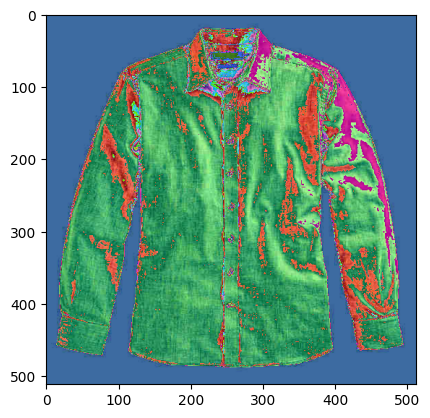

In [50]:
shirt_mask_pil = transforms.ToPILImage()(shirt_img[0].cpu())

# Print and display the shirt mask image for debugging
print("Shirt Mask PIL Image:")
plt.imshow(shirt_mask_pil)
plt.show()



Shirt Mask PIL Image:


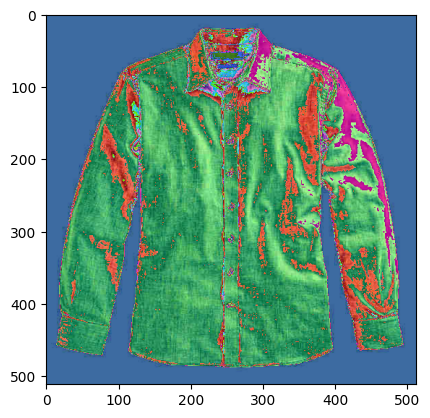

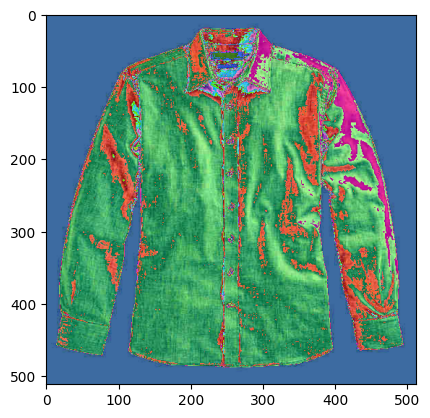

In [56]:
import numpy as np

# Convert the tensor mask to a PIL Image
shirt_mask_pil = transforms.ToPILImage()(shirt_img[0].cpu())

# Print and display the shirt mask image for debugging
print("Shirt Mask PIL Image:")
plt.imshow(shirt_mask_pil)
plt.show()

# Convert the input image and shirt mask image to NumPy arrays
input_image_array = np.array(input_image)
shirt_mask_array = np.array(shirt_mask_pil)

# Apply the mask to the input image to get the combined image
combined_image_array = np.copy(input_image_array)
combined_image_array[shirt_mask_array > 0] = shirt_mask_array[shirt_mask_array > 0]

# Convert the combined image array back to a PIL Image
combined_image_pil = Image.fromarray(combined_image_array)

# Display the combined image
plt.imshow(combined_image_pil)
plt.show()


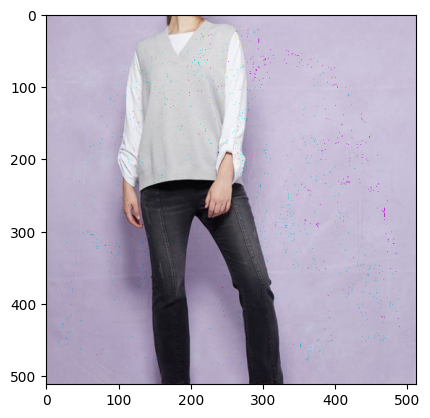

  0%|          | 0/40 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


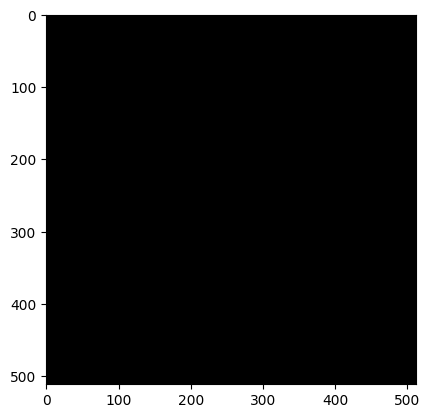

In [73]:
# ... (previous code)

import numpy as np

# Convert the tensor mask to a NumPy array
shirt_mask_array = np.array(shirt_mask_pil)

# Convert the input image to a NumPy array
input_image_array = np.array(input_image)

# Convert the mask to a binary mask (0s and 1s)
binary_mask = (shirt_mask_array > 0).astype(np.uint8)

# Invert the binary mask
inverted_mask = 1 - binary_mask

# Use broadcasting to extract the shirt region from the input image
shirt_region = input_image_array * inverted_mask

# Use broadcasting to remove the shirt region from the input image
background = input_image_array * binary_mask

# Resize the shirt image array to match the shape of the binary mask
shirt_image_array_resized = np.resize(shirt_image_array, binary_mask.shape)

# Use NumPy masked array to combine the images using the shirt mask
combined_image_array = np.ma.masked_array(shirt_image_array_resized, mask=binary_mask).filled(background)

# Convert the combined image array back to a PIL Image
combined_image_pil = Image.fromarray(combined_image_array.astype(np.uint8))

# Display the combined image
plt.imshow(combined_image_pil)
plt.show()

# ... (rest of the code)
# Convert the combined image to a PyTorch tensor
combined_image_tensor = torch.tensor(np.array(combined_image_pil)).unsqueeze(0).permute(0, 3, 1, 2).float()

# Convert the shirt mask to a PyTorch tensor
shirt_mask_tensor = torch.tensor(np.array(shirt_mask_pil)).unsqueeze(0).permute(0, 3, 1, 2).float()

# Use the inpainting model to inpaint the combined image
with autocast("cuda"):
    dummy_prompt = "red shirt"
    output_image_tensor = pipe(prompt=dummy_prompt, image=combined_image_tensor, mask_image=shirt_mask_tensor, strength=0.8).images[0]

# Display the inpainted output image
plt.imshow(output_image_tensor)
plt.show()
